In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time
import tflearn, psutil, gc
from datetime import datetime
%matplotlib inline

In [66]:
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.estimator import regression

In [67]:
from rlx.utils import humanbytes
print "free mem", humanbytes(psutil.virtual_memory().free)

free mem 1.06 GB


# We will be creating the same CNN  for binary classification of MNIST (even/odd)

## load the data

In [68]:
from tensorflow.examples.tutorials.mnist.input_data import read_data_sets
mnist = read_data_sets("/tmp/MNIST_data/", one_hot=True, reshape=False, validation_size=0)
print "free mem", humanbytes(psutil.virtual_memory().free)

Extracting /tmp/MNIST_data/train-images-idx3-ubyte.gz
Extracting /tmp/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /tmp/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/MNIST_data/t10k-labels-idx1-ubyte.gz
free mem 783.03 MB


In [69]:
print mnist.train.images.shape
print mnist.test.images.shape

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [70]:
cnames = {0: "even", 1: "odd"}

In [72]:
# number of images used for training and test
n=len(mnist.train.images)

cnames = {0: "even", 1: "odd"}
from sklearn.preprocessing import OneHotEncoder

idxs = np.random.permutation(range(len(mnist.train.images)))[:n]
train_imgs = mnist.train.images[idxs]
train_labels = np.r_[[np.argwhere(i)[0][0] for i in mnist.train.labels[idxs]]]%2
train_ohlabs = OneHotEncoder().fit_transform(train_labels.reshape(-1,1)).toarray().astype(int)

In [73]:
vn = n if n<mnist.test.images.shape[0] else mnist.test.images.shape[0]

idxs = np.random.permutation(range(len(mnist.test.images)))[:n]
test_imgs = mnist.test.images[idxs]
test_labels = np.r_[[np.argwhere(i)[0][0] for i in mnist.test.labels[idxs]]]%2
test_ohlabs = OneHotEncoder().fit_transform(test_labels.reshape(-1,1)).toarray().astype(int)

In [74]:
print train_imgs.shape, test_imgs.shape
print train_labels.shape, test_labels.shape
print train_ohlabs.shape, test_ohlabs.shape
print "free mem", humanbytes(psutil.virtual_memory().free)

(60000, 28, 28, 1) (10000, 28, 28, 1)
(60000,) (10000,)
(60000, 2) (10000, 2)
free mem 602.33 MB


In [75]:
del(mnist)
gc.collect()
print "free mem", humanbytes(psutil.virtual_memory().free)

free mem 868.86 MB


In [76]:
print pd.Series(train_labels).value_counts()
print pd.Series(test_labels).value_counts()

1    30508
0    29492
dtype: int64
1    5074
0    4926
dtype: int64


## use `tflearn` to create network

In [77]:
num_classes = train_ohlabs.shape[1]

tf.reset_default_graph()

network1 = input_data(shape=[None, 28, 28, 1])
network2 = conv_2d(network1, 9, 5, strides=1, activation='relu', name="conv1", padding="SAME")
network3 = conv_2d(network2, 18, 4, strides=2, activation='relu', name="conv2", padding="SAME")
network4 = fully_connected(network3, 100, activation='relu', name='fc1')
network5 = fully_connected(network4, num_classes, activation='softmax', name='fc2')
network6 = regression(network5, optimizer="adam",  loss='categorical_crossentropy')

model   = tflearn.DNN(network6, tensorboard_verbose=0, tensorboard_dir="log")
print type(model), type(network6)

<class 'tflearn.models.dnn.DNN'> <class 'tensorflow.python.framework.ops.Tensor'>


In [78]:
gc.collect()
print "free mem", humanbytes(psutil.virtual_memory().free)

free mem 866.43 MB


## train and use `tensorboard` to see progress and results

In [79]:
model_name = "tflearn_cnn_binmnist_" + datetime.now().strftime("%Y-%m-%d_%H:%M")
print "model name", model_name

model name tflearn_cnn_binmnist_2018-01-11_13:15


In [80]:
# Training
model.fit(train_imgs, train_ohlabs, n_epoch=10,  validation_set=(test_imgs, test_ohlabs), shuffle=True,
          show_metric=True, batch_size=100, snapshot_step=100, snapshot_epoch=False, run_id=model_name)

Training Step: 5999  | total loss: 0.00416 | time: 105.788s
| Adam | epoch: 010 | loss: 0.00416 - acc: 0.9988 -- iter: 59900/60000
Training Step: 6000  | total loss: 0.00387 | time: 109.636s
| Adam | epoch: 010 | loss: 0.00387 - acc: 0.9989 | val_loss: 0.02676 - val_acc: 0.9933 -- iter: 60000/60000
--


(5, 5, 1, 9)


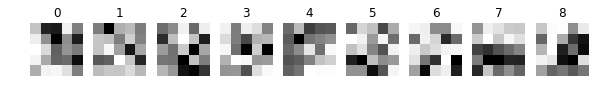

In [81]:
w1 = model.get_weights(tflearn.get_all_trainable_variable()[0])
print w1.shape
def display_imgs(w, figsize=(10,3)):
    plt.figure(figsize=figsize)
    for i in range(w.shape[-1]):
        plt.subplot(1,w.shape[-1],i+1)
        plt.imshow(w[:,:,i], cmap = plt.cm.Greys_r, interpolation="none")
        plt.axis("off")
        plt.title(i)

display_imgs(w1[:,:,0,:])

## save weights in h5 file

In [85]:
vars = {i.name:i for i in tflearn.variables.get_all_trainable_variable()}
vars

{u'conv1/W:0': <tf.Variable 'conv1/W:0' shape=(5, 5, 1, 9) dtype=float32_ref>,
 u'conv1/b:0': <tf.Variable 'conv1/b:0' shape=(9,) dtype=float32_ref>,
 u'conv2/W:0': <tf.Variable 'conv2/W:0' shape=(4, 4, 9, 18) dtype=float32_ref>,
 u'conv2/b:0': <tf.Variable 'conv2/b:0' shape=(18,) dtype=float32_ref>,
 u'fc1/W:0': <tf.Variable 'fc1/W:0' shape=(3528, 100) dtype=float32_ref>,
 u'fc1/b:0': <tf.Variable 'fc1/b:0' shape=(100,) dtype=float32_ref>,
 u'fc2/W:0': <tf.Variable 'fc2/W:0' shape=(100, 2) dtype=float32_ref>,
 u'fc2/b:0': <tf.Variable 'fc2/b:0' shape=(2,) dtype=float32_ref>}

In [90]:
import h5py
fname = 'pretrained_models/binmnist.h5'
h5f = h5py.File(fname, 'w')
for k in np.sort(vars.keys()):
    val = model.get_weights(vars[k])
    print "saving", k, val.shape
    h5f.create_dataset(k, data=val)
h5f.close()
print "weights saved into", fname

saving conv1/W:0 (5, 5, 1, 9)
saving conv1/b:0 (9,)
saving conv2/W:0 (4, 4, 9, 18)
saving conv2/b:0 (18,)
saving fc1/W:0 (3528, 100)
saving fc1/b:0 (100,)
saving fc2/W:0 (100, 2)
saving fc2/b:0 (2,)
weights saved into pretrained_models/binmnist.h5
